In [6]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e5/9e/0d57922cf46b9e91de636cd5b5e0d7a424ebe98f3245380a713f1f6c2a0b/tensorflow-2.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/ee/1b/00a78aa2e8fbd63f9af08c9c19e6deb3d5d66b4dda677a0f61654680ee89/flatbuffers-25.9.23-py2.py3-none-any.whl.metadata
  Obtaining dependency information for google_pasta>=0.1.1 from https://files.pythonhosted.org/packages/a3/de/c648ef6835192e6e2cc03f40b19eeda4382c49b5bafb43d88b931c4c74ac/google_pasta-0.2.0-py3-none-any.whl.metadata
  Obtaining dependen

  Obtaining dependency information for tensorboard-data-server<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/7a/13/e503968fefabd4c6b2650af21e110aa8466fe21432cd7c43a84577a89438/tensorboard_data_server-0.7.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.4/620.4 MB 194.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 272.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 232.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 135.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 228.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 233.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 217.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 233.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 330.4 MB/s eta 0:00:00
   ━━━━

In [21]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [6]:
# Data processing functions
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    # Updated to match the newer librosa version
    rms = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rms)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result, zcr(data, frame_length, hop_length), rmse(data, frame_length, hop_length), mfcc(data, sr, frame_length, hop_length)))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)
    
    noised_audio = noise(data)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))
    
    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))
    
    pitched_noised_audio = noise(pitch(data, sr))
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))
    
    return audio

In [ ]:
# --- UNZIP ALL DATASETS AUTOMATICALLY (for SCC project structure) ---

import os, zipfile, glob

# Root path for your Kaggle-style folder inside project space
root = "/projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input"

# Find and unzip all .zip files recursively
zips = glob.glob(os.path.join(root, "**", "*.zip"), recursive=True)

print(f"Found {len(zips)} zip files under {root}")
for z in zips:
    dest = os.path.dirname(z)
    print(f"Unzipping: {os.path.basename(z)} → {dest}")
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(dest)
print(" All archives extracted!\n")

# --- DEFINE DATA PATHS (using your project layout) ---
ravdess = f"{root}/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema   = f"{root}/cremad/AudioWAV/"
Tess    = f"{root}/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee   = f"{root}/surrey-audiovisual-expressed-emotion-savee/ALL/"

print("Dataset paths ready:")
for name, path in {
    "RAVDESS": ravdess, "CREMA-D": Crema,
    "TESS": Tess, "SAVEE": Savee
}.items():
    pr


Found 4 zip files under /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input
Unzipping: ALL.zip → /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input/surrey-audiovisual-expressed-emotion-savee
Unzipping: AudioWAV.zip → /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input/cremad
Unzipping: audio_speech_actors_01-24.zip → /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input/ravdess-emotional-speech-audio


KeyboardInterrupt: 

In [8]:
ravdess = "./kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "./kaggle/input/cremad/AudioWAV/"
Tess = "./kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "./kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [9]:
import os, glob, pandas as pd
from pathlib import Path

# make sure these four point to the *folders with wavs* (your earlier cell set these)
# ravdess = ".../ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
# Crema   = ".../cremad/AudioWAV/"
# Tess    = ".../toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
# Savee   = ".../surrey-audiovisual-expressed-emotion-savee/ALL/"

def list_wavs(root):
    """Return a sorted list of .wav files under root (recursive)."""
    if not root or not os.path.isdir(root):
        return []
    return sorted(glob.glob(os.path.join(root, "**", "*.wav"), recursive=True))

def process_ravdess(root):
    # filenames like 03-01-05-01-01-01-01.wav  -> part[2] is emotion id
    id2emo = {"01":"neutral","02":"neutral","03":"happy","04":"sad","05":"angry",
              "06":"fear","07":"disgust","08":"surprise"}
    paths, emos, skipped = [], [], 0
    for p in list_wavs(root):
        name = Path(p).name
        parts = name.split(".")[0].split("-")
        if len(parts) >= 3 and parts[2] in id2emo:
            emos.append(id2emo[parts[2]])
            paths.append(p)
        else:
            skipped += 1
    df = pd.DataFrame({"Emotions": emos, "Path": paths})
    return df, skipped

def process_cremad(root):
    # e.g., 1001_DFA_ANG_XX.wav -> part[2] is ANG, DIS, FEA, HAP, NEU, SAD
    map3 = {"SAD":"sad","ANG":"angry","DIS":"disgust","FEA":"fear",
            "HAP":"happy","NEU":"neutral"}
    paths, emos, skipped = [], [], 0
    for p in list_wavs(root):
        name = Path(p).name
        parts = name.split("_")
        if len(parts) >= 3 and parts[2] in map3:
            emos.append(map3[parts[2]])
            paths.append(p)
        else:
            skipped += 1
    return pd.DataFrame({"Emotions": emos, "Path": paths}), skipped

def process_tess(root):
    # filenames like OAF_back_angry.wav -> ... split("_")[2] == 'angry'
    paths, emos, skipped = [], [], 0
    for p in list_wavs(root):
        name = Path(p).name
        head = name.split(".")[0]
        parts = head.split("_")
        if len(parts) >= 3:
            emo = parts[2]
            emo = "surprise" if emo == "ps" else emo  # keep kaggle notebook behavior
            emos.append(emo)
            paths.append(p)
        else:
            skipped += 1
    return pd.DataFrame({"Emotions": emos, "Path": paths}), skipped

def process_savee(root):
    # e.g., DC_a01.wav, DC_sa01.wav, DC_su01.wav
    tag2emo = {
        "a": "angry", "d": "disgust", "f": "fear", "h": "happy",
        "n": "neutral", "sa": "sad", "su": "surprise"
    }
    paths, emos, skipped = [], [], 0
    for p in list_wavs(root):
        name = Path(p).name
        parts = name.split("_")
        if len(parts) >= 2:
            tag = parts[1].split(".")[0]  # a01, sa01, su01...
            # normalize tag to its letter(s)
            if tag.startswith("sa"): key = "sa"
            elif tag.startswith("su"): key = "su"
            else: key = tag[0] if tag else ""
            if key in tag2emo:
                emos.append(tag2emo[key])
                paths.append(p)
            else:
                skipped += 1
        else:
            skipped += 1
    return pd.DataFrame({"Emotions": emos, "Path": paths}), skipped

def process_datasets():
    rav_df, r_skip = process_ravdess(ravdess)
    cr_df, c_skip = process_cremad(Crema)
    te_df, t_skip = process_tess(Tess)
    sa_df, s_skip = process_savee(Savee)

    print(f"RAVDESS: {len(rav_df)} files (skipped {r_skip}) from {ravdess}")
    print(f"CREMA-D: {len(cr_df)} files (skipped {c_skip}) from {Crema}")
    print(f"TESS:    {len(te_df)} files (skipped {t_skip}) from {Tess}")
    print(f"SAVEE:   {len(sa_df)} files (skipped {s_skip}) from {Savee}")

    return pd.concat([rav_df, cr_df, te_df, sa_df], axis=0, ignore_index=True)

In [10]:
data_path = process_datasets()


RAVDESS: 2880 files (skipped 0) from ./kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/
CREMA-D: 7442 files (skipped 0) from ./kaggle/input/cremad/AudioWAV/
TESS:    5600 files (skipped 0) from ./kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/
SAVEE:   480 files (skipped 0) from ./kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/


In [11]:
# Extract features and labels
X, Y = [], []
for path, emotion in zip(data_path['Path'], data_path['Emotions']):
    features = get_features(path)
    for i in features:
        X.append(i)
        Y.append(emotion)

KeyboardInterrupt: 

In [ ]:
len(X), len(Y), data_path.Path.shape


(65608, 65608, (16402,))

In [12]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('./kaggle/working/emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518,neutral
1,0.246582,0.375488,0.498047,0.500000,0.491699,0.484375,0.490723,0.495605,0.500488,0.514648,...,-0.401886,0.616554,-2.234189,-3.202118,-3.147747,-4.746160,-3.508554,-0.544277,2.461443,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.006744,0.006628,0.006513,0.006383,0.006247,0.006113,0.005947,0.005783,0.005614,neutral
3,0.247070,0.362793,0.487305,0.495117,0.500977,0.509766,0.515625,0.502930,0.500488,0.498535,...,1.561245,5.088081,-0.390821,-2.586333,-0.053067,-0.774264,-0.271001,0.241193,0.917824,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [ ]:
Emotions = pd.read_csv('./kaggle/working/emotion.csv').fillna(0)

In [ ]:
X = Emotions.iloc[:, :-1].values
Y = Emotions['Emotions'].values

In [ ]:
# One-hot to match your current pipeline; we'll convert to class indices for PyTorch
encoder = OneHotEncoder()
Y_oh = encoder.fit_transform(Y.reshape(-1, 1)).toarray()   # (N, C)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y_oh, random_state=42, test_size=0.2, shuffle=True
)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

In [ ]:
# Optional artifact to mirror your previous save
np.save('x_train.npy', x_train)

In [ ]:
# 2) Tensors for Conv1D
# Conv1D expects (batch, channels=1, length=F)
x_train_t = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
x_test_t  = torch.tensor(x_test,  dtype=torch.float32).unsqueeze(1)

In [ ]:
# CrossEntropyLoss needs class indices (not one-hot)
y_train_idx = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)
y_test_idx  = torch.tensor(np.argmax(y_test,  axis=1), dtype=torch.long)

train_ds = TensorDataset(x_train_t, y_train_idx)
test_ds  = TensorDataset(x_test_t,  y_test_idx)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  drop_last=False)
val_loader   = DataLoader(test_ds,  batch_size=256, shuffle=False, drop_last=False)

In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self, in_len, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 512, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(512, 512, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),

            nn.Conv1d(512, 256, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),

            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.2),
        )
        # infer flattened size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_len)
            flat_dim = self.features(dummy).numel()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_len = x_train_t.shape[-1]
num_classes = y_train_idx.max().item() + 1
model = EmotionCNN(in_len, num_classes).to(device)

In [ ]:
# 4) Optimizer, loss, scheduler, early stopping, checkpoint
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=10, factor=0.5, min_lr=1e-5,
)

In [ ]:
best_path = "best_model1_weights.pt"
best_val_acc = 0.0
epochs_no_improve = 0
early_patience = 20
epochs = 50

def evaluate(loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            preds = logits.argmax(1)
            total += yb.size(0)
            correct += (preds == yb).sum().item()
            loss_sum += loss.item() * yb.size(0)
    return loss_sum / total, correct / total

# 5) Train & record history
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, epochs + 1):
    model.train()
    tr_loss_sum, tr_total, tr_correct = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        tr_loss_sum += loss.item() * yb.size(0)
        tr_total += yb.size(0)
        tr_correct += (logits.argmax(1) == yb).sum().item()

    tr_loss = tr_loss_sum / tr_total
    tr_acc  = tr_correct / tr_total
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step(val_acc)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train_loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val_loss {val_loss:.4f} acc {val_acc:.4f}")

    # checkpoint + early stopping
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_patience:
            print(f"Early stopping at epoch {epoch} (best val_acc={best_val_acc:.4f})")
            break

print("Best val_acc:", best_val_acc, "| saved:", best_path)

# ---- 6) Reload best and final eval ----
best_model = EmotionCNN(in_len, num_classes).to(device)
best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()
final_loss, final_acc = evaluate(val_loader)
print(f"Final (best) val_loss {final_loss:.4f} acc {final_acc:.4f}")


Epoch 01/50 | train_loss 1.8383 acc 0.3397 | val_loss 4.2500 acc 0.2879
Epoch 02/50 | train_loss 0.8091 acc 0.6908 | val_loss 2.3190 acc 0.5303
Epoch 03/50 | train_loss 0.6234 acc 0.7824 | val_loss 0.7584 acc 0.6970
Epoch 04/50 | train_loss 0.4215 acc 0.8664 | val_loss 0.5862 acc 0.7879
Epoch 05/50 | train_loss 0.3780 acc 0.8969 | val_loss 0.6633 acc 0.7727
Epoch 06/50 | train_loss 0.3405 acc 0.9237 | val_loss 0.5224 acc 0.7727
Epoch 07/50 | train_loss 0.2120 acc 0.9733 | val_loss 0.5022 acc 0.8333
Epoch 08/50 | train_loss 0.1831 acc 0.9695 | val_loss 0.5606 acc 0.7879
Epoch 09/50 | train_loss 0.1808 acc 0.9695 | val_loss 0.4365 acc 0.8788
Epoch 10/50 | train_loss 0.1388 acc 0.9885 | val_loss 0.5115 acc 0.7879
Epoch 11/50 | train_loss 0.1324 acc 0.9733 | val_loss 0.4732 acc 0.7879
Epoch 12/50 | train_loss 0.0957 acc 0.9885 | val_loss 0.6356 acc 0.8030
Epoch 13/50 | train_loss 0.0811 acc 0.9924 | val_loss 0.5574 acc 0.8333
Epoch 14/50 | train_loss 0.0788 acc 0.9885 | val_loss 0.4375 acc

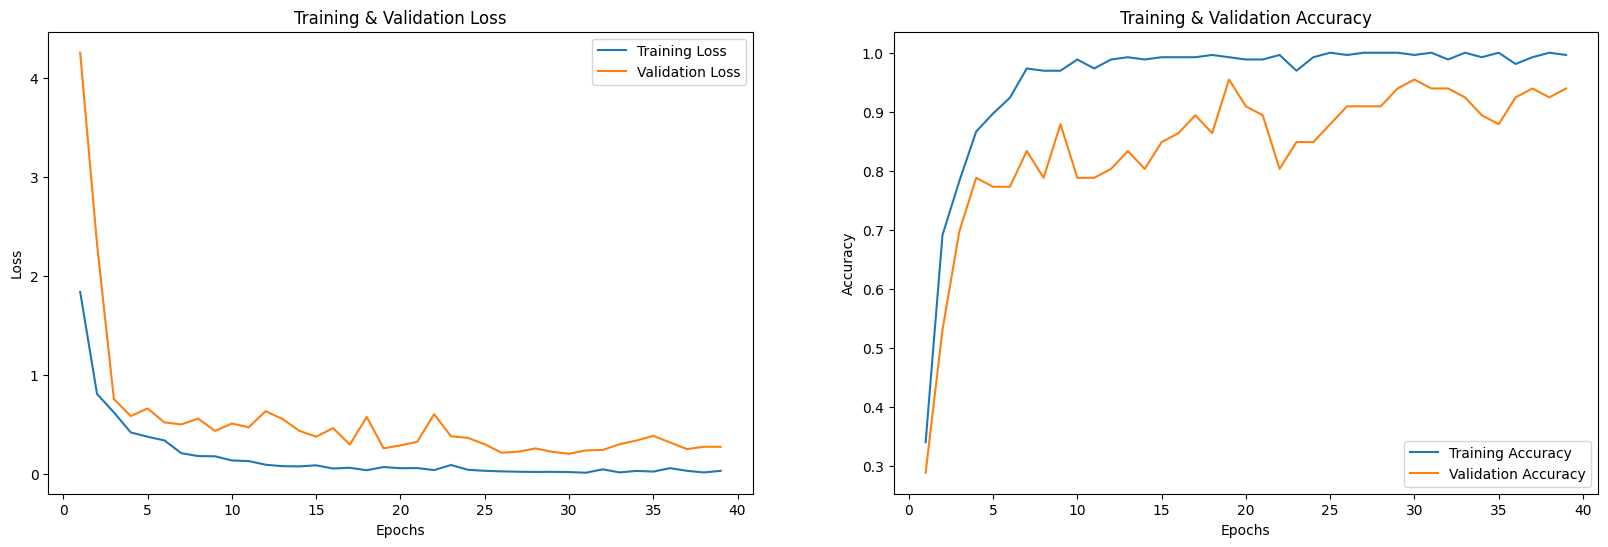

Example predicted labels: ['surprise' 'sad' 'neutral' 'neutral' 'sad' 'surprise' 'happy' 'disgust'
 'disgust' 'sad']


In [ ]:
# 7) Plot history (Keras-style) ----
epochs_range = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Training Loss")
plt.plot(epochs_range, history["val_loss"], label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Training Accuracy")
plt.plot(epochs_range, history["val_acc"], label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

plt.show()

# 8) Example inference (probs & class names) ----
with torch.no_grad():
    xb = x_test_t.to(device)
    probs = torch.softmax(best_model(xb), dim=1).cpu().numpy()
    preds = probs.argmax(axis=1)

label_names = encoder.categories_[0]  # in the encoder's order
pred_labels = label_names[preds]
print("Example predicted labels:", pred_labels[:10])


Test loss: 0.2611  Test Accuracy: 95.45%
              precision    recall  f1-score   support

       angry       0.83      1.00      0.91         5
     disgust       0.86      1.00      0.92         6
        fear       1.00      0.88      0.93         8
       happy       1.00      0.94      0.97        17
     neutral       1.00      0.94      0.97        17
         sad       1.00      1.00      1.00        10
    surprise       0.75      1.00      0.86         3

    accuracy                           0.95        66
   macro avg       0.92      0.97      0.94        66
weighted avg       0.96      0.95      0.96        66



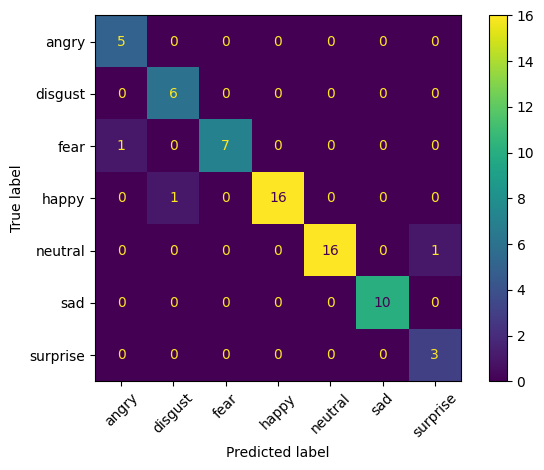

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Use the best checkpoint if you saved it; otherwise use the current model
model_to_eval = best_model if 'best_model' in locals() else model
model_to_eval.eval()

all_preds, all_true = [], []
test_loss_sum, total = 0.0, 0

with torch.no_grad():
    for xb, yb in val_loader:   # <- this is your test loader (built from x_test/y_test)
        xb, yb = xb.to(device), yb.to(device)
        logits = model_to_eval(xb)
        loss = criterion(logits, yb)

        test_loss_sum += loss.item() * yb.size(0)
        total += yb.size(0)

        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

# Aggregate
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)
test_loss = test_loss_sum / total
test_acc = (y_pred == y_true).mean()

print(f"Test loss: {test_loss:.4f}  Test Accuracy: {test_acc * 100:.2f}%")

# Map indices -> class names (same order as your OneHotEncoder)
target_names = encoder.categories_[0]
print(classification_report(y_true, y_pred, target_names=target_names))

# (Optional) Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(xticks_rotation=45)
plt.tight_layout()
plt.show()
